In [261]:
import numpy as np
import scipy as scp

import matplotlib.pyplot as plt

## Assumptions

In its simplest form, the BOCPD algorithm assumes the following generative model for regularly sampled observations $x_t$

$$\begin{align}
r_{t + 1} &= \begin{cases}
0 & \text{ with prob. } \lambda \\
r_t + 1 & \text{ otherwise,}
\end{cases} \\
\theta_{t + 1} &= \begin{cases}
\theta \sim p(\theta), & \text{ if } r_{t+1} = 0 \\
\theta_t & \text{ otherwise,}
\end{cases} \\
x_{t + 1} &\sim p(x_{t + 1} | \theta_{t+1})
\end{align}$$

with $r_0 = 1$. In other words, at each time step the model determines whether to produce a changepoint, by resetting the run length $r_{t + 1} = 0$ and re-sampling the parameters $\theta_{t + 1}$, and then generates a datum $x_{t + 1}$. In general

## Sampling from the prior

In [262]:
mu0 = 0.
beta = 0.1
a = 10.
b = 0.05
p = 0.1

gamma = np.random.gamma(shape=a, scale=b**-1)

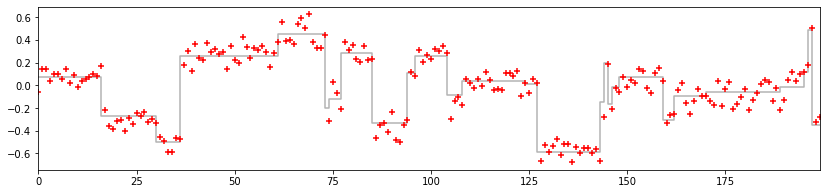

In [263]:
np.random.seed(0)

T = 200
t = np.arange(T)
        
lamda_ = np.random.gamma(shape=a, scale=b**-1)
mu_ = np.random.normal(mu0, (beta * lamda_) ** -0.5)

mu = [mu_]
lamda = [lamda_]
x = []

for t_ in t[:-1]:
        
    x_ = np.random.normal(mu_, lamda_**-0.5)
    
    if np.random.choice([True, False], p=[p, 1-p]):
        
        lamda_ = np.random.gamma(shape=a, scale=b**-1)
        mu_ = np.random.normal(mu0, (beta * lamda_) ** -0.5)
        
    mu.append(mu_)
    lamda.append(lamda_)
    x.append(x_)
        
x.append(np.random.normal(mu_, lamda_**-0.5))
x = np.array(x)

plt.figure(figsize=(14, 3))
plt.step(t, np.array(mu), color='k', zorder=1, alpha=0.3)
plt.scatter(t, x, color='red', marker='+', zorder=2)
plt.xlim([0, T-1])
plt.show()

## BOCPD

In [264]:
mu0 = 0.
beta = 0.01
a = 10.
b = 0.1
p = 0.1

r_max = 100

def cond_pred(t, x, r_max, mu0, beta, a, b):
    
    """
    Conditional predictive p(x[t] | x[1:t-1], r) for Gaussian (G) a likelihood
    with a Normal-Gamma (NG) prior.
    
    The predictive of a G-NG model is Student's t-distribution. For the
    posterior updates and and the predictive distribution equations see
    
        https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf
        
    Args:
        t (int)        : time to compute the predictive, p(x[t] | x[1:t-1], r)
        x (np.ndarray) : training data - shape (T,)
        r_max (int)    : maximum run length allowed
        mu0 (float)    : NG mean-of-mean parameter (in Normal)
        beta (float)   : NG precision-of-mean parameter (in Normal)
        a (float)      : NG a parameter (in Gamma)
        b (float)      : NG b parameter (in Gamma)
        
    Returns:
        cond_pred (np.ndarray) : conditional predictive - shape (r_max,)
    """
    
    # Array to hold the conditional predictive
    cond_pred = np.zeros(shape=(r_max,))
    
    for r in range(r_max):
        
        # Slice all predictions from t-r (floored at 0) to t-1
        xr = x[max(0, t-r):t]
        
        # Number of datapoints conditioning on
        n = xr.shape[0]
        
        # Handle the case where n is 0 - posterior equals prior in this case
        mean = np.mean(xr) if n > 0 else 0.
        nvar = n * np.var(xr) if n > 0 else 0.
        
        # NG posterior updates
        post_mu = (beta * mu0 + n * mean) / (beta + n)
        post_beta = beta + n
        post_a = a + 0.5 * n
        post_b = b + 0.5 * nvar + \
                 0.5 * beta * n * (mean - mu0) ** 2 / (beta + n)
        
        # Parameters of Student-t predictive posterior
        mu_pred_post = post_mu
        prec_pred_post = (post_a * post_beta) / (post_b * (post_beta + 1))
        df_pred_post = 2 * post_a
        
        # Compute p(x[t] | x[1:t-1], r) for given r
        cond_pred[r] = scp.stats.t.pdf(x[t],
                                       df=df_pred_post,
                                       loc=mu_pred_post,
                                       scale=prec_pred_post**-0.5)
                         
    return cond_pred


def compute_next_posterior(r_post, cond_pred, p):
    """
    Compute next posterior p(r | x[1:t]) from current posterior p(r | x[1:t-1])
    and conditional predictive p(x[t] | x[1:t-1], r).
    """
    
    next_r_post = np.zeros_like(r_post)
    next_r_post[0] = p * cond_pred[0] * np.sum(r_post)
    next_r_post[1:] = (1 - p) * r_post[:-1] * cond_pred[:-1]
    
    next_r_post = next_r_post / np.sum(next_r_post)
    
    return next_r_post
    
    
def infer(x, p, r_max, mu0, beta, a, b):
    
    r_post = np.zeros(shape=(x.shape[0], r_max))
    r_post[0, 0] = 1.
    
    for t in range(1, x.shape[0]):
        
        cond_pred_ = cond_pred(t, x, r_max, mu0, beta, a, b)
        r_post[t, :] = compute_next_posterior(r_post[t-1, :], cond_pred=cond_pred_, p=p)
        
    return r_post

r_post = infer(x=x,
               p=p,
               r_max=r_max,
               mu0=mu0,
               beta=beta,
               a=a,
               b=b)

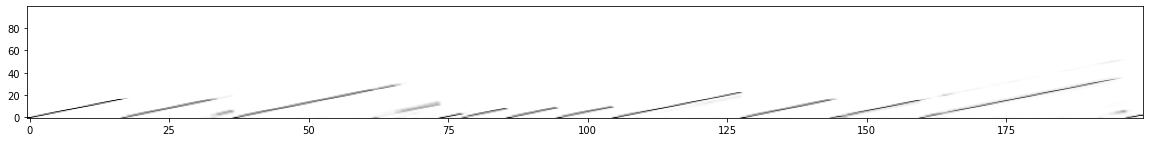

In [265]:
plt.figure(figsize=(20, 8))
plt.imshow(r_post.T, origin='xy', cmap='binary', aspect=0.2)
plt.show()